In [80]:
# from bpnetlite import BPNet, ChromBPNet
from tangermeme.io import extract_loci
from tangermeme.predict import predict
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from models import BPExtractor
import data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import gzip

import importlib

importlib.reload(data)

from data import sample_tpm_rows, remove_duplicate_edges, build_enhancer_graph

In [2]:
model = BPNet.from_chrombpnet("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/ATAC/ENCSR291GJU/chrombpnet_model/chrombpnet_wo_bias.h5")

In [3]:
peak_file = "/oak/stanford/groups/akundaje/kobbad/CS224W/data/ENCFF439EIO.bed.gz"
ref_genome = "/oak/stanford/groups/akundaje/kobbad/CS224W/data/hg38.fa"
signal = "/oak/stanford/groups/akundaje/kobbad/CS224W/data/ENCFF262URW.bigWig"

loci, signals = extract_loci(peak_file, ref_genome, [signal], verbose=True)

Loading Loci: 100%|██████████| 279739/279739 [01:31<00:00, 3055.57it/s]


In [4]:
peaks_df = pd.read_csv(peak_file, sep="\t", header=None)

peaks_df.shape, loci.shape, signals.shape

((279739, 10), torch.Size([279739, 4, 2114]), torch.Size([279739, 1, 1000]))

In [5]:
predictions = predict(model, loci, batch_size=8, verbose=True)

100%|██████████| 34968/34968 [14:29<00:00, 40.23it/s]


In [12]:
preds_numpy = predictions[1].numpy()
actual_counts = np.log1p(signals.sum(axis=2))

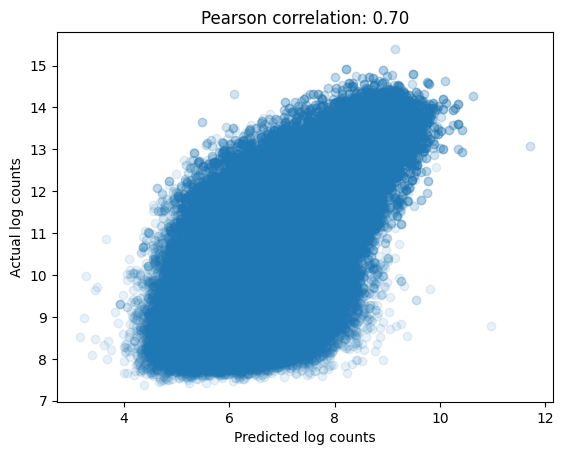

In [19]:
plt.scatter(preds_numpy, actual_counts, alpha=0.1);
plt.xlabel("Predicted log counts");
plt.ylabel("Actual log counts");

# calculate pearsonr
pearon_corr = pearsonr(preds_numpy.squeeze(), actual_counts.squeeze())[0]

plt.title(f"Pearson correlation: {pearon_corr:.2f}");


create embeddings

In [25]:
# wrapper class to get embeddings 
model_embedding = BPExtractor(model)

In [29]:
embeddings = predict(model_embedding, loci, batch_size=8, verbose=True)

100%|██████████| 34968/34968 [14:26<00:00, 40.37it/s]


In [31]:
embeddings_numpy = embeddings.numpy()


In [32]:
output_dir = "/oak/stanford/groups/akundaje/kobbad/CS224W/data"
embeddings_file_name = "embeddings.npz"

np.savez_compressed(f"{output_dir}/{embeddings_file_name}", embeddings=embeddings_numpy)

Processing expression data

In [6]:
expression_tsv = "./data/ENCFF103FSL.tsv"

expression_df = pd.read_csv(expression_tsv, sep="\t")

gene_mask = [gene.startswith("ENSG") for gene in  expression_df['gene_id']]

print(f"Original shape: {expression_df.shape}")
expression_df = expression_df[gene_mask]
print(f"Filtered shape: {expression_df.shape}")

Original shape: (59526, 17)
Filtered shape: (58780, 17)


In [7]:
import pandas as pd

# Define column names for GTF files
gtf_columns = [
    "seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"
]

# Read the GTF file
gtf_df = pd.read_csv(
    "./data/gencode.v38.chr_patch_hapl_scaff.basic.annotation.gtf.gz",
    sep="\t",
    comment="#",
    names=gtf_columns,
    compression="gzip"
)

# Display the first few rows
gtf_df.head()


,seqname,source,feature,start,end,score,strand,frame,attribute
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN..."


In [12]:
gtf_df = gtf_df[gtf_df.feature == 'gene']


In [27]:
gene_name = [i.split(" ")[1].strip('"')[:17] for i in gtf_df.attribute]

gtf_df['gene_name'] = gene_name

In [29]:
gtf_df.head(), gtf_df.shape

(   seqname   source feature  start    end score strand frame  \
 0     chr1   HAVANA    gene  11869  14409     .      +     .   
 12    chr1   HAVANA    gene  14404  29570     .      -     .   
 25    chr1  ENSEMBL    gene  17369  17436     .      -     .   
 28    chr1   HAVANA    gene  29554  31109     .      +     .   
 36    chr1  ENSEMBL    gene  30366  30503     .      +     .   
 
                                             attribute          gene_name  
 0   gene_id "ENSG00000223972.5"; gene_type "transc...  ENSG00000223972.5  
 12  gene_id "ENSG00000227232.5"; gene_type "unproc...  ENSG00000227232.5  
 25  gene_id "ENSG00000278267.1"; gene_type "miRNA"...  ENSG00000278267.1  
 28  gene_id "ENSG00000243485.5"; gene_type "lncRNA...  ENSG00000243485.5  
 36  gene_id "ENSG00000284332.1"; gene_type "miRNA"...  ENSG00000284332.1  ,
 (67049, 10))

In [39]:
gene_annots = gtf_df[['seqname', 'start', 'end', 'gene_name']]
gene_annots = gene_annots.rename(columns={'gene_name': 'gene_id'})


In [43]:
print(expression_df['gene_id'].dtype)
print(gene_annots['gene_id'].dtype)


object
object


In [45]:
print(expression_df['gene_id'].unique()[:10])  # First 10 unique values
print(gene_annots['gene_id'].unique()[:10])


['ENSG00000000003.14' 'ENSG00000000005.5' 'ENSG00000000419.12'
 'ENSG00000000457.13' 'ENSG00000000460.16' 'ENSG00000000938.12'
 'ENSG00000000971.15' 'ENSG00000001036.13' 'ENSG00000001084.12'
 'ENSG00000001167.14']
['ENSG00000223972.5' 'ENSG00000227232.5' 'ENSG00000278267.1'
 'ENSG00000243485.5' 'ENSG00000284332.1' 'ENSG00000237613.2'
 'ENSG00000268020.3' 'ENSG00000240361.2' 'ENSG00000186092.7'
 'ENSG00000238009.6']


In [49]:
expression_df['gene_id'] = expression_df['gene_id'].str.strip()
gene_annots['gene_id'] = gene_annots['gene_id'].str.strip()


In [46]:
expression_df['gene_id'] = expression_df['gene_id'].astype(str)
gene_annots['gene_id'] = gene_annots['gene_id'].astype(str)


In [51]:
expression_df.head()

,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation
649,ENSG00000000003.14,"ENST00000373020.8,ENST00000494424.1,ENST000004...",2186.44,2014.32,8699.0,59.92,78.22,8699.0,0.0,58.99,78.10,57.698800,60.257500,0.007519,76.455300,79.843200,0.007520
650,ENSG00000000005.5,"ENST00000373031.4,ENST00000485971.1",940.50,768.40,0.0,0.00,0.00,0.0,0.0,0.05,0.06,0.001101,0.125704,0.510979,0.001458,0.166506,0.510985
651,ENSG00000000419.12,"ENST00000371582.8,ENST00000371584.8,ENST000003...",1077.91,905.78,4756.0,72.85,95.10,4756.0,0.0,71.80,95.06,69.787000,73.869200,0.009835,92.447200,97.851000,0.009851
652,ENSG00000000457.13,"ENST00000367770.5,ENST00000367771.10,ENST00000...",3755.24,3583.12,575.0,2.23,2.91,575.0,0.0,2.25,2.97,2.020040,2.483520,0.035457,2.670460,3.284820,0.035507
653,ENSG00000000460.16,"ENST00000286031.10,ENST00000359326.8,ENST00000...",2651.49,2479.37,2062.0,11.54,15.06,2062.0,0.0,11.53,15.26,10.739900,12.301100,0.023351,14.222900,16.290300,0.023349


In [52]:
gene_annots.head()

,seqname,start,end,gene_id
0,chr1,11869,14409,ENSG00000223972.5
12,chr1,14404,29570,ENSG00000227232.5
25,chr1,17369,17436,ENSG00000278267.1
28,chr1,29554,31109,ENSG00000243485.5
36,chr1,30366,30503,ENSG00000284332.1


In [53]:
# drop na values in both dataframes
expression_df = expression_df.dropna()
gene_annots = gene_annots.dropna()

In [55]:
joined_df = expression_df.merge(
    gene_annots,
    left_on='gene_id',
    right_on='gene_id',
    how='inner'
)


In [58]:
joined_df.head()

,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation,seqname,start,end
0,ENSG00000015413.9,"ENST00000261615.5,ENST00000393092.7,ENST000004...",1552.38,1380.26,1689.00,16.98,22.16,1689.00,0.00,17.24,22.82,1.627720e+01,18.235300,0.019549,2.152150e+01,24.114800,0.019546,chr16,89613308,89638456
1,ENSG00000016602.9,"ENST00000370563.3,ENST00000496322.1",1846.50,1674.41,0.00,0.00,0.00,0.00,0.00,0.05,0.06,3.566140e-04,0.135670,0.585217,6.143510e-04,0.179921,0.585284,chr1,86547078,86580754
2,ENSG00000019995.6,"ENST00000359653.4,ENST00000471421.1",5318.42,5146.30,3277.53,8.84,11.54,3277.72,16.26,8.73,11.56,8.298080e+00,9.207870,0.017953,1.098850e+01,12.193300,0.017970,chr10,124942123,124988189
3,ENSG00000020219.9,ENST00000465400.1,1674.00,1501.88,0.00,0.00,0.00,0.00,0.00,0.01,0.01,1.985500e-07,0.027279,0.655443,2.630510e-07,0.036145,0.655540,chr7,152445477,152447150
4,ENSG00000037241.7,"ENST00000265100.6,ENST00000519156.1,ENST000005...",703.41,531.41,1446.81,37.78,49.31,1446.31,0.95,37.49,49.64,3.547350e+01,39.621900,0.018913,4.694960e+01,52.446400,0.018928,chr5,172958729,172969771


In [64]:
gene_data_df = joined_df[['gene_id','seqname','start','end','TPM']]

gene_data_df.to_csv("./data/gene_data.tsv", sep="\t", index=False)

For each gene - identify the peaks the are with X mb of the gene

In [19]:
peak_file = "/oak/stanford/groups/akundaje/kobbad/CS224W/data/ENCFF439EIO.bed.gz"
gene_data = "./data/gene_data.tsv"

gene_data_df = pd.read_csv(gene_data, sep="\t")
peaks = pd.read_csv(peak_file, sep="\t", header=None)
peaks = peaks.drop_duplicates(subset=peaks.columns[[0, 1, 2]])
peaks.head()

,0,1,2,3,4,5,6,7,8,9
0,chr1,100027088,100027511,Peak_148646,681,.,5.21938,68.17744,66.18713,312
1,chr1,100036823,100037403,Peak_159959,592,.,2.48719,59.27093,57.31506,487
4,chr1,100037575,100038997,Peak_291677,175,.,1.72480,17.52787,15.84093,63
8,chr1,100088104,100088842,Peak_249842,238,.,3.15522,23.86811,22.11509,630
9,chr1,100130513,100131017,Peak_130287,874,.,2.96036,87.48827,85.43484,104


In [20]:
gene_data_df.head()

,gene_id,seqname,start,end,TPM
0,ENSG00000015413.9,chr16,89613308,89638456,16.98
1,ENSG00000016602.9,chr1,86547078,86580754,0.00
2,ENSG00000019995.6,chr10,124942123,124988189,8.84
3,ENSG00000020219.9,chr7,152445477,152447150,0.00
4,ENSG00000037241.7,chr5,172958729,172969771,37.78


In [21]:
genes = sample_tpm_rows(gene_data_df, 10)

In [22]:
window_size = 500_000

gene_name, chrom, start, end, label = genes.loc[0]

In [23]:
adj_peaks = peaks[(peaks[1] > start - window_size) & (peaks[2] < end + window_size) & (peaks[0] == chrom)]

In [25]:
adj_peaks.shape

(64, 10)

In [43]:
# Read the file into a DataFrame, skipping rows that start with '#'
with gzip.open("./data/ENCFF050EKS.bedpe.gz", 'rt') as f:
    hic_data = pd.read_csv(f, sep='\t', comment='#', header=None)

# Display the first few rows to confirm it's read correctly
hic_data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,chr10,128265000,128270000,chr10,128530000,128535000,.,.,.,.,...,7.526189,6.603142,5.856136e-05,9.156019e-07,1.311771e-06,1.313665e-06,1,128267500,128532500,0
1,chr10,95245000,95250000,chr10,95290000,95295000,.,.,.,.,...,26.631159,28.102118,2.088254e-04,2.264645e-04,3.061460e-04,2.886754e-04,1,95247500,95292500,0
2,chr10,112225000,112230000,chr10,112305000,112310000,.,.,.,.,...,36.944256,44.125946,4.627799e-12,7.955021e-18,6.489944e-12,4.647555e-07,5,112221500,112306500,9055
3,chr10,77715000,77720000,chr10,77760000,77765000,.,.,.,.,...,24.568014,19.378069,2.667134e-03,2.878671e-03,3.693836e-03,2.707774e-05,1,77717500,77762500,0
4,chr10,110745000,110750000,chr10,110890000,110895000,.,.,.,.,...,13.497053,11.824867,1.512103e-06,1.250660e-06,2.315090e-04,1.962619e-06,1,110747500,110892500,0


In [46]:
chrom, start, end, *_ = adj_peaks.iloc[0]

adj_hic_data = hic_data[(hic_data[0] == chrom) & (hic_data[1] < start + 1000) & (hic_data[2] > end - 1000)]

In [47]:
adj_hic_data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23


In [40]:
adj_hic_data

,chr1,x1,x2,chr2,y1,y2,name,score,strand1,strand2,color,score2,uVarScore,lVarScore,upSign,loSign
5478,chr7,77360000,77610000,chr7,77360000,77610000,.,.,.,.,"255,255,0",1.381418,0.106416,0.08832,0.793846,0.669231


In [41]:
hic_data

,chr1,x1,x2,chr2,y1,y2,name,score,strand1,strand2,color,score2,uVarScore,lVarScore,upSign,loSign
0,chr10,9340000,11280000,chr10,9340000,11280000,.,.,.,.,"255,255,0",0.433953,0.414897,0.371543,0.422337,0.498070
1,chr10,35610000,36860000,chr10,35610000,36860000,.,.,.,.,"255,255,0",0.714591,0.334032,0.408696,0.614984,0.408063
2,chr10,50940000,52220000,chr10,50940000,52220000,.,.,.,.,"255,255,0",0.559678,0.344074,0.371474,0.609012,0.518471
3,chr10,119980000,120775000,chr10,119980000,120775000,.,.,.,.,"255,255,0",0.447077,0.333908,0.348539,0.509844,0.420625
4,chr10,94620000,95075000,chr10,94620000,95075000,.,.,.,.,"255,255,0",0.452866,0.322908,0.348360,0.588374,0.423913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6178,chr9,130495000,130575000,chr9,130495000,130575000,.,.,.,.,"255,255,0",0.730647,0.037231,0.022822,0.513889,0.513889
6179,chr9,36785000,36855000,chr9,36785000,36855000,.,.,.,.,"255,255,0",0.882437,0.033949,0.024875,0.517857,0.553571
6180,chr9,128955000,129025000,chr9,128955000,129025000,.,.,.,.,"255,255,0",0.793959,0.035941,0.021849,0.589286,0.553571
6181,chr9,121545000,121615000,chr9,121545000,121615000,.,.,.,.,"255,255,0",0.816573,0.039780,0.015126,0.553571,0.517857


In [51]:
embeddings = np.load("./data/embeddings.npz")
embeddings = embeddings['embeddings']

In [83]:
embeddings = torch.tensor(embeddings)
embeddings.shape

torch.Size([279739, 512])

In [81]:
W = 1000  # Define your distance threshold
edge_index = build_enhancer_graph(adj_peaks, W)
print(edge_index)

(tensor([[10, 20, 30, 40, 58],
        [11, 21, 31, 41, 59]]), tensor([249611, 249616, 249620, 249627, 249630, 249631, 249632, 249634, 249635,
        249636, 249637, 249640, 249642, 249643, 249644, 249645, 249647, 249648,
        249650, 249651, 249658, 249659, 249660, 249661, 249662, 249663, 249664,
        249665, 249666, 249667, 249668, 249669, 249670, 249672, 249673, 249678,
        249680, 249682, 249684, 249685, 249687, 249688, 249689, 249694, 249697,
        249698, 249700, 249701, 249702, 249703, 249704, 249709, 249711, 249712,
        249713, 249714, 249715, 249716, 249717, 249718, 249719, 249721, 249724,
        249725]))


In [85]:
embeddings[edge_index[1]].shape

torch.Size([64, 512])